### **- Using analyst recommendations data to determine whether the stock price will rise or not.**

#### Here I am using analyst recommendations data, to predict whether the stock price moved significantly in the following month from when the above reports released.

#### For better results I am using only Hold and Buy as values for the target column, since I am taking the maximum **close** value of the stock price for the following month of each report.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

2024-09-18 22:50:12.007256: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 22:50:12.007842: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 22:50:12.009787: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 22:50:12.015655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 22:50:12.025278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
analyst_rcmd = pd.read_json('AnalystData/AAPL_RCMD.json')
analyst_rcmd_df = pd.DataFrame(analyst_rcmd)
analyst_rcmd_df['dym'] = analyst_rcmd_df['date'].dt.to_period('M')
analyst_rcmd_df

,symbol,date,analystRatingsbuy,analystRatingsHold,analystRatingsSell,analystRatingsStrongSell,analystRatingsStrongBuy,dym
0,AAPL,2024-07-01,21,6,0,0,11,2024-07
1,AAPL,2024-06-01,19,12,1,0,12,2024-06
2,AAPL,2024-05-01,19,13,1,0,10,2024-05
3,AAPL,2024-04-01,24,7,1,0,10,2024-04
4,AAPL,2024-03-01,24,7,1,0,10,2024-03
...,...,...,...,...,...,...,...,...
62,AAPL,2019-04-01,10,22,1,0,15,2019-04
63,AAPL,2019-03-01,10,22,1,0,15,2019-03
64,AAPL,2019-02-01,10,22,1,0,15,2019-02
65,AAPL,2019-01-01,14,18,0,0,17,2019-01


In [3]:
rcmd_min_date = analyst_rcmd_df['date'].min()
today = datetime.date.today()
stock_prices_df = yf.download('AAPL', rcmd_min_date, today)

[*********************100%%**********************]  1 of 1 completed


In [4]:
stock_prices_df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close'], inplace=True)
stock_prices_df

,Adj Close
Date,
2018-12-03,44.180405
2018-12-04,42.236965
2018-12-06,41.766060
2018-12-07,40.276798
2018-12-10,40.542133
...,...
2024-09-11,222.660004
2024-09-12,222.770004
2024-09-13,222.500000


#### - Here I tried going with the max_next_3 or the maximum price for the following 3 months, but that yielded far worse results, but maybe it can be made more effective, so I left it as a comment.

In [5]:
# monthly_max_df['max_next_3'] = (
#     monthly_max_df['Adj Close']  # Replace 'price' with the actual column name for stock prices
#     .shift(-1)  # Shift the values to align with the start of the window
#     .rolling(window=3, min_periods=1)  # Define a 3-month rolling window
#     .max()
# )

monthly_max_df = stock_prices_df['Adj Close'].resample('M').max().to_frame()

monthly_max_df['dym'] = monthly_max_df.index.to_period('M')
monthly_max_df

,Adj Close,dym
Date,,
2018-12-31,44.180405,2018-12
2019-01-31,39.786755,2019-01
2019-02-28,41.981174,2019-02
2019-03-31,46.835430,2019-03
2019-04-30,49.809891,2019-04
...,...,...
2024-05-31,192.127625,2024-05
2024-06-30,216.419495,2024-06
2024-07-31,234.548523,2024-07


In [6]:
analyst_rcmd_df['dym'] = analyst_rcmd_df['date'].dt.to_period('M') 
analyst_rcmd_df

,symbol,date,analystRatingsbuy,analystRatingsHold,analystRatingsSell,analystRatingsStrongSell,analystRatingsStrongBuy,dym
0,AAPL,2024-07-01,21,6,0,0,11,2024-07
1,AAPL,2024-06-01,19,12,1,0,12,2024-06
2,AAPL,2024-05-01,19,13,1,0,10,2024-05
3,AAPL,2024-04-01,24,7,1,0,10,2024-04
4,AAPL,2024-03-01,24,7,1,0,10,2024-03
...,...,...,...,...,...,...,...,...
62,AAPL,2019-04-01,10,22,1,0,15,2019-04
63,AAPL,2019-03-01,10,22,1,0,15,2019-03
64,AAPL,2019-02-01,10,22,1,0,15,2019-02
65,AAPL,2019-01-01,14,18,0,0,17,2019-01


In [7]:
merged_df = pd.merge(analyst_rcmd_df, monthly_max_df, how='left', left_on='dym', right_on='dym')
merged_df = merged_df.sort_values('dym', ascending=True)
merged_df = merged_df.reset_index(drop=True)
merged_df

,symbol,date,analystRatingsbuy,analystRatingsHold,analystRatingsSell,analystRatingsStrongSell,analystRatingsStrongBuy,dym,Adj Close
0,AAPL,2018-12-01,14,18,0,0,17,2018-12,44.180405
1,AAPL,2019-01-01,14,18,0,0,17,2019-01,39.786755
2,AAPL,2019-02-01,10,22,1,0,15,2019-02,41.981174
3,AAPL,2019-03-01,10,22,1,0,15,2019-03,46.835430
4,AAPL,2019-04-01,10,22,1,0,15,2019-04,49.809891
...,...,...,...,...,...,...,...,...,...
62,AAPL,2024-03-01,24,7,1,0,10,2024-03,179.209229
63,AAPL,2024-04-01,24,7,1,0,10,2024-04,176.107025
64,AAPL,2024-05-01,19,13,1,0,10,2024-05,192.127625
65,AAPL,2024-06-01,19,12,1,0,12,2024-06,216.419495


#### - In the following cell I am creating the target column **trend**. We have percentage_limit that defines what should our criteria be for determening whether the stock price has risen significantly or not. I tried different options for this value, and it seems it depends what kind of stock we have, and how much data we have. It works differently for diffent kind of scenarios. I would maybe improve this part by cross validating this value and see for what value perhaps from 0 to 10 the models give the best result.

#### - Calculating the percentage change from the next row and the current row, then creating an interval that defines our Hold or Buy target column using the pct_change column.

In [8]:
percentage_limit = 0
merged_df['pct_change'] = (merged_df['Adj Close'].shift(-1) - merged_df['Adj Close'] ) / merged_df['Adj Close'].shift(-1) * 100

# merged_df['trend'] = pd.cut(merged_df['pct_change'], bins=[-float('inf'), -percentage_limit, percentage_limit,
#                                                            float('inf')], labels=['Sell', 'Hold', 'Buy'])
merged_df['trend'] = pd.cut(merged_df['pct_change'], bins=[-float('inf'), percentage_limit,
                                                           float('inf')], labels=['Hold', 'Buy'])


In [9]:
merged_df

,symbol,date,analystRatingsbuy,analystRatingsHold,analystRatingsSell,analystRatingsStrongSell,analystRatingsStrongBuy,dym,Adj Close,pct_change,trend
0,AAPL,2018-12-01,14,18,0,0,17,2018-12,44.180405,-11.042997,Hold
1,AAPL,2019-01-01,14,18,0,0,17,2019-01,39.786755,5.227152,Buy
2,AAPL,2019-02-01,10,22,1,0,15,2019-02,41.981174,10.364495,Buy
3,AAPL,2019-03-01,10,22,1,0,15,2019-03,46.835430,5.971626,Buy
4,AAPL,2019-04-01,10,22,1,0,15,2019-04,49.809891,2.016548,Buy
...,...,...,...,...,...,...,...,...,...,...,...
62,AAPL,2024-03-01,24,7,1,0,10,2024-03,179.209229,-1.761544,Hold
63,AAPL,2024-04-01,24,7,1,0,10,2024-04,176.107025,8.338519,Buy
64,AAPL,2024-05-01,19,13,1,0,10,2024-05,192.127625,11.224437,Buy
65,AAPL,2024-06-01,19,12,1,0,12,2024-06,216.419495,7.729330,Buy


In [10]:
ready_df = merged_df.drop(columns=['date', 'dym', 'symbol', 'pct_change', 'Adj Close'], inplace=False)
ready_df['trend'].isna().sum()

1

In [11]:
ready_df = ready_df.dropna(subset=['trend'])


In [12]:

label_encoder = LabelEncoder()
ready_df['trend'] = label_encoder.fit_transform(ready_df['trend'])
ready_df

,analystRatingsbuy,analystRatingsHold,analystRatingsSell,analystRatingsStrongSell,analystRatingsStrongBuy,trend
0,14,18,0,0,17,1
1,14,18,0,0,17,0
2,10,22,1,0,15,0
3,10,22,1,0,15,0
4,10,22,1,0,15,0
...,...,...,...,...,...,...
61,24,7,1,0,10,1
62,24,7,1,0,10,1
63,24,7,1,0,10,0
64,19,13,1,0,10,0


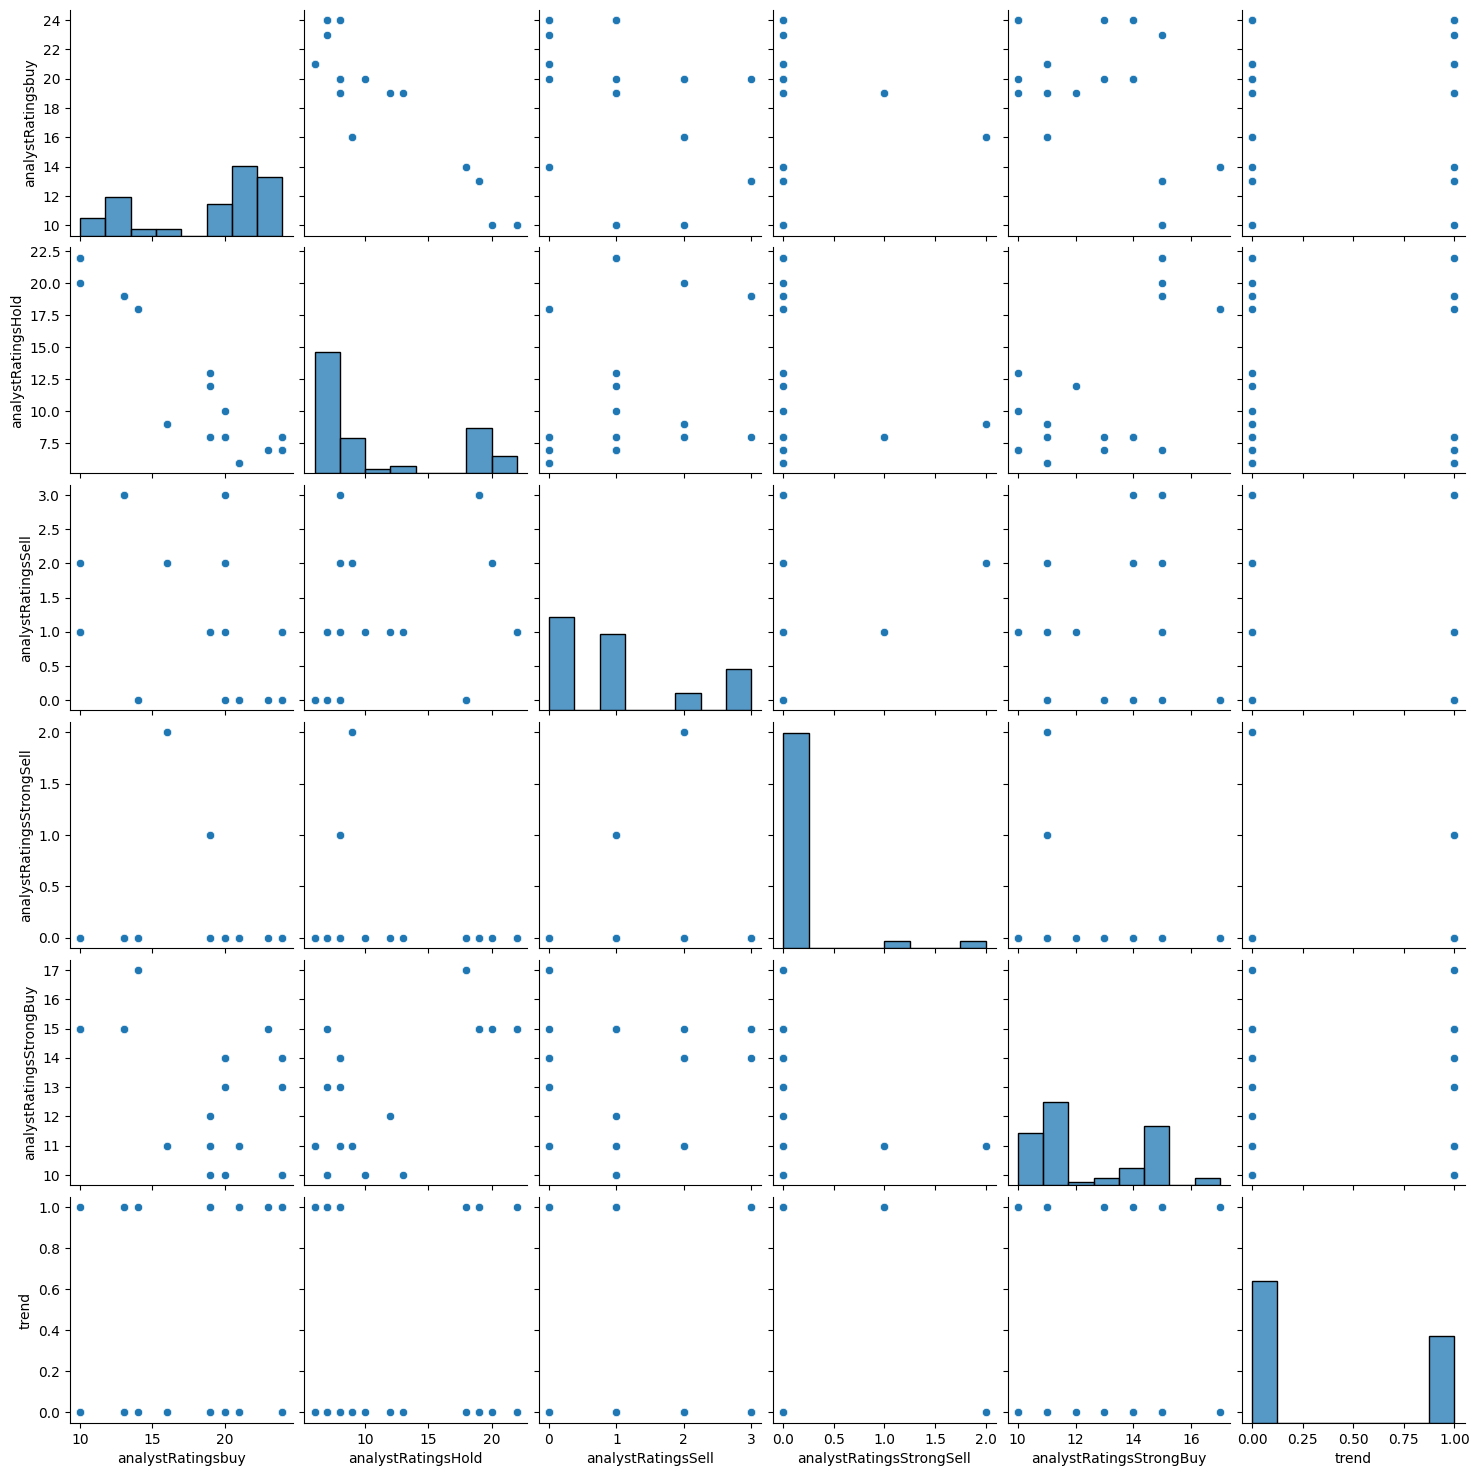

In [13]:
sns.pairplot(ready_df)

#### Tried splitting the data with a TimeSeriesSplit because it seems more natural, since we are predicting the future based on past data.
#### This yielded almost the same results as a basic train_test_split, so I left it like this. I am considering changing it in insider_data and eps_revenue predictions as well.

In [14]:
X = ready_df.drop(columns='trend', inplace=False)
y = ready_df['trend']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Tried the time series split looking for better results

tscv = TimeSeriesSplit(n_splits=6)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [15]:
X_train, y_train

(    analystRatingsbuy  analystRatingsHold  analystRatingsSell  \
 0                  14                  18                   0   
 1                  14                  18                   0   
 2                  10                  22                   1   
 3                  10                  22                   1   
 4                  10                  22                   1   
 5                  10                  22                   1   
 6                  10                  20                   2   
 7                  13                  19                   3   
 8                  13                  19                   3   
 9                  13                  19                   3   
 10                 13                  19                   3   
 11                 13                  19                   3   
 12                 13                  19                   3   
 13                 13                  19                   3   
 14       

In [16]:
X_test, y_test

(    analystRatingsbuy  analystRatingsHold  analystRatingsSell  \
 57                 24                   7                   1   
 58                 24                   7                   1   
 59                 24                   7                   1   
 60                 24                   7                   1   
 61                 24                   7                   1   
 62                 24                   7                   1   
 63                 24                   7                   1   
 64                 19                  13                   1   
 65                 19                  12                   1   
 
     analystRatingsStrongSell  analystRatingsStrongBuy  
 57                         0                       10  
 58                         0                       10  
 59                         0                       10  
 60                         0                       10  
 61                         0                       1

In [17]:
y_train.value_counts()

trend
0    36
1    21
Name: count, dtype: int64

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

modelLog = LogisticRegression(penalty='l2', C=1.0)

cv_scores = cross_val_score(modelLog, X_scaled, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Cross-Validation Scores: [0.71428571 0.38461538 0.23076923 0.30769231 0.61538462]
Mean CV Score: 0.45054945054945056


In [19]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.57      1.00      0.73         4

    accuracy                           0.67         9
   macro avg       0.79      0.70      0.65         9
weighted avg       0.81      0.67      0.64         9

Accuracy: 0.6666666666666666


In [29]:
label_encoder.inverse_transform(y_pred)

array(['Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy', 'Buy'],
      dtype=object)

In [20]:
merged_df.tail(1)

,symbol,date,analystRatingsbuy,analystRatingsHold,analystRatingsSell,analystRatingsStrongSell,analystRatingsStrongBuy,dym,Adj Close,pct_change,trend
66,AAPL,2024-07-01,21,6,0,0,11,2024-07,234.548523,NaN,NaN


In [21]:
new_data = merged_df.tail(1).drop(columns=['date', 'dym', 'symbol', 'pct_change', 'trend', 'Adj Close'], inplace=False)
new_data

,analystRatingsbuy,analystRatingsHold,analystRatingsSell,analystRatingsStrongSell,analystRatingsStrongBuy
66,21,6,0,0,11


In [22]:
predicted_trend_encoded = model.predict(new_data)
predicted_trend = label_encoder.inverse_transform(predicted_trend_encoded)

print("Predicted Trend:", predicted_trend)

Predicted Trend: ['Buy']


In [23]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: Buy, Hold
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# print(classification_report(y_test, y_pred, target_names=['Buy', 'Hold', 'Hold']))
print(classification_report(y_test, y_pred, target_names=['Buy', 'Hold']))
print(confusion_matrix(y_test, y_pred))

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4880 - loss: 0.8483 - val_accuracy: 0.5000 - val_loss: 0.8636
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6986 - loss: 0.5950 - val_accuracy: 0.5833 - val_loss: 0.6800
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6782 - loss: 0.5894 - val_accuracy: 0.6667 - val_loss: 0.6688
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6329 - loss: 0.6218 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6421 - loss: 0.6348 - val_accuracy: 0.5000 - val_loss: 0.6761
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6347 - loss: 0.6151 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7181 - loss: 0.5891 - val_accuracy: 0.5000 - val_loss: 0.7787
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6222 - loss: 0.6778 - val_accuracy: 0.5000 - val_loss: 0.6806
Epoch 9

/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
predicted_trend_encoded = model.predict(new_data)
y_pred_new_data = np.argmax(predicted_trend_encoded, axis=1)
predicted_trend = label_encoder.inverse_transform(y_pred_new_data)

print("Predicted Trend:", predicted_trend)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Trend: ['Buy']


In [25]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
model.fit(X_train, y_train)
# model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

# Evaluate the model
# print(classification_report(y_test, y_pred, target_names=['Buy', 'Hold', 'Hold']))
print(classification_report(y_test, y_pred, target_names=['Buy', 'Hold']))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         Buy       0.56      1.00      0.71         5
        Hold       0.00      0.00      0.00         4

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9

[[5 0]
 [4 0]]


/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
predicted_trend_encoded = model.predict(new_data)
predicted_trend = label_encoder.inverse_transform(predicted_trend_encoded)

print("Predicted Trend:", predicted_trend)

Predicted Trend: ['Buy']
